## Sampler template

This notebook contains the basic syntax required to run a chain. We set up a mock data object, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.data import data_MPGADGET
from lace_manager.emulator import p1d_archive_Nyx
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
import time

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
emu_type="k_bin"

In [3]:
use_nyx=False
if use_nyx:
    nyx_fname='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5'
else:
    nyx_fname=None

In [4]:
# specify simulation to use to generate synthetic data
test_sim_label="diffSeed"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [5]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,nyx_fname=nyx_fname,polyfit=(emu_type=='polyfit'))

### Emulator and training set

Create a set of training data to train an emulator

In [6]:
if use_nyx:
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=nyx_fname,verbosity=0)
else:
    archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [7]:
## Build emulator
if use_nyx:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
    kmax_Mpc=2
else:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
    kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.13 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [8]:
free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
free_param_names=["As","ns","ln_tau_0"]
prior=0.5

In [9]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,include_CMB=False)

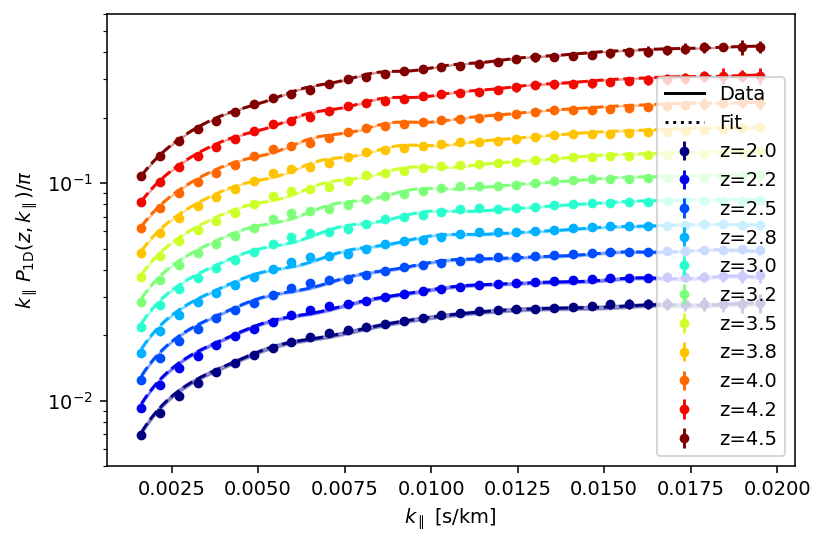

In [10]:
like.plot_p1d(residuals=False)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [11]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,verbose=False,
                        nwalkers=10,
                        save_chain=True,
                        progress=True)

Created directory: /Users/font/Projects/LaCE_manager//lace_manager/sampler/chains//chain_42


In [12]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


In [13]:
n_burn_in=20
n_steps=2000 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|███████████████████████████████████████| 2020/2020 [13:21<00:00,  2.52it/s]

Sampling took 801.8 seconds


Mean values: [0.4831313700036299, 0.981180532251196, 0.36308417493770456]


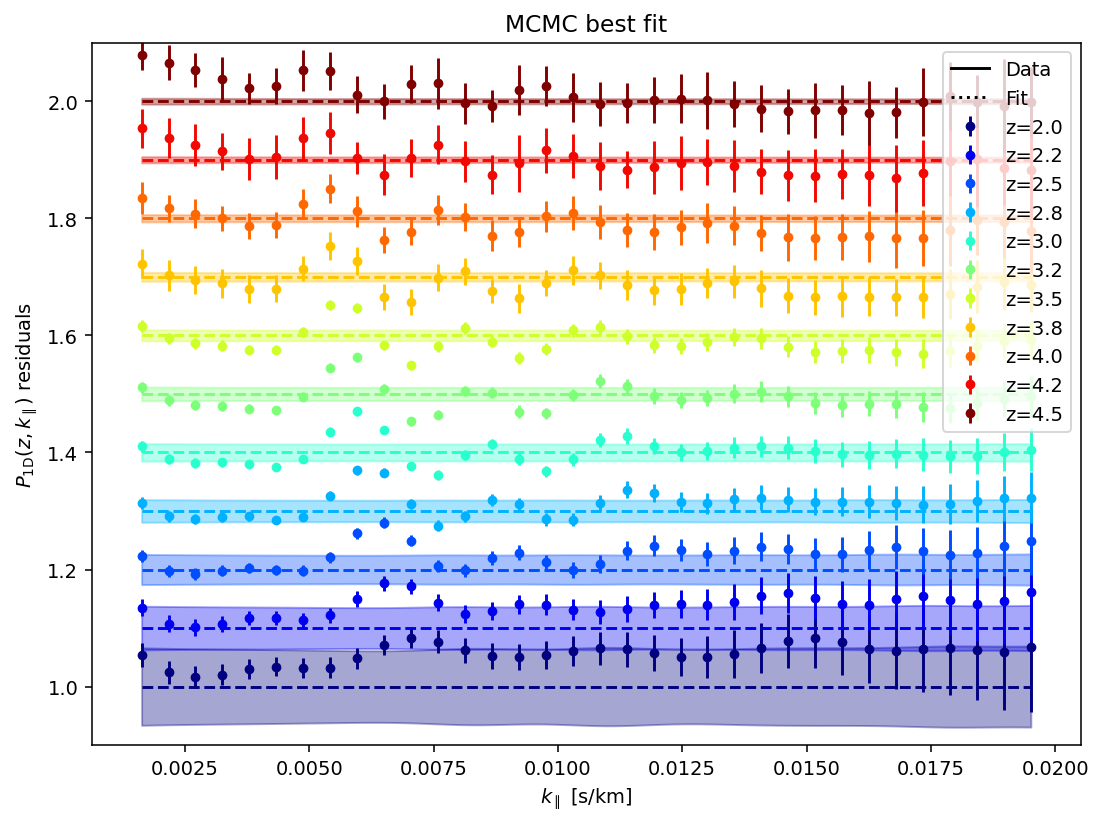

<Figure size 840x560 with 0 Axes>

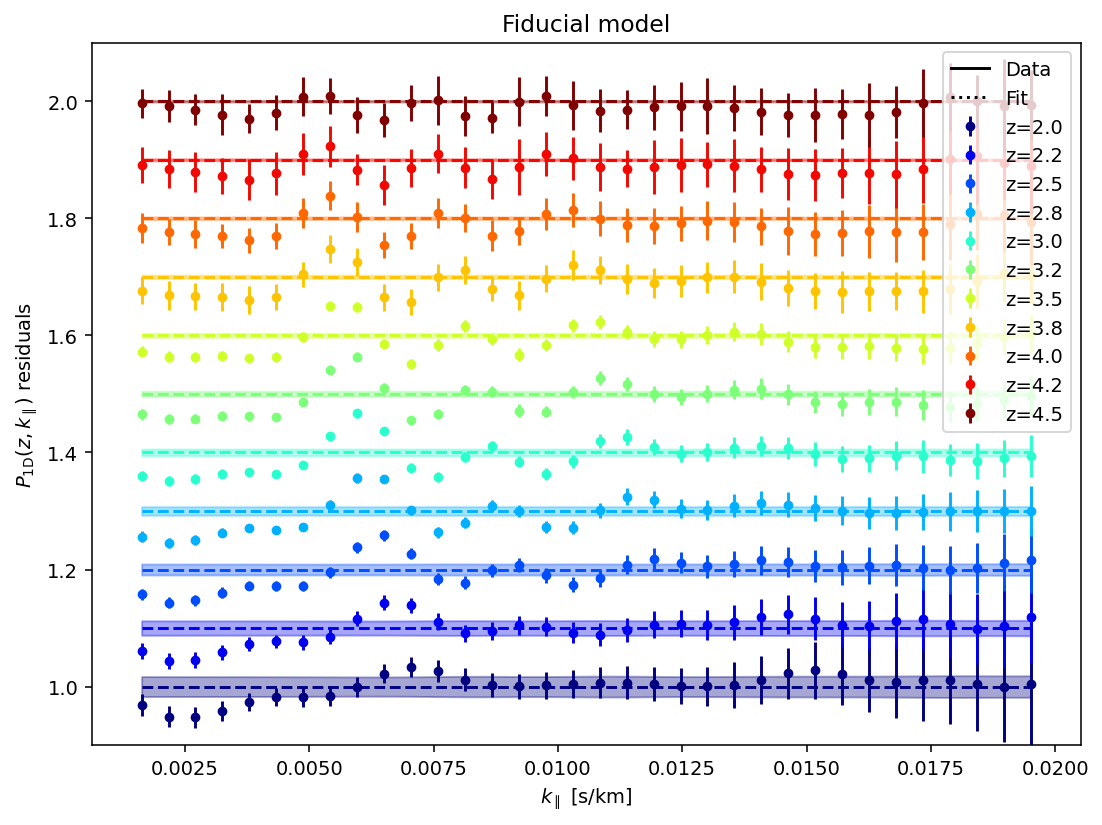

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/pyt

Can't plot corner


<Figure size 840x560 with 0 Axes>

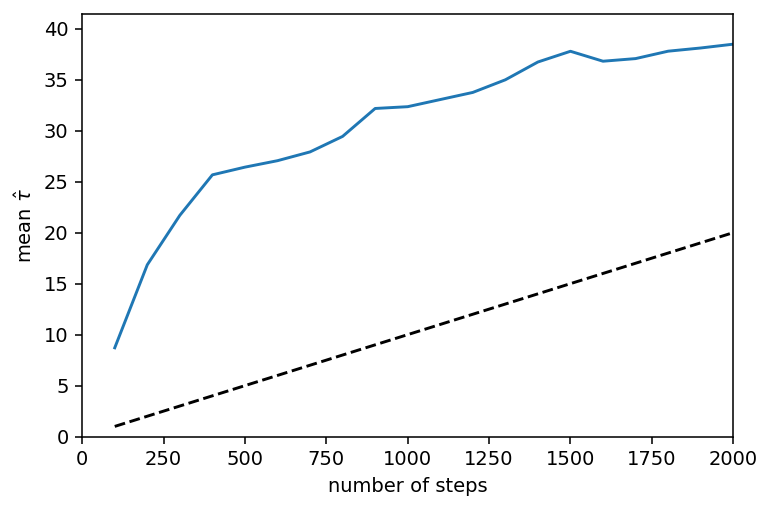

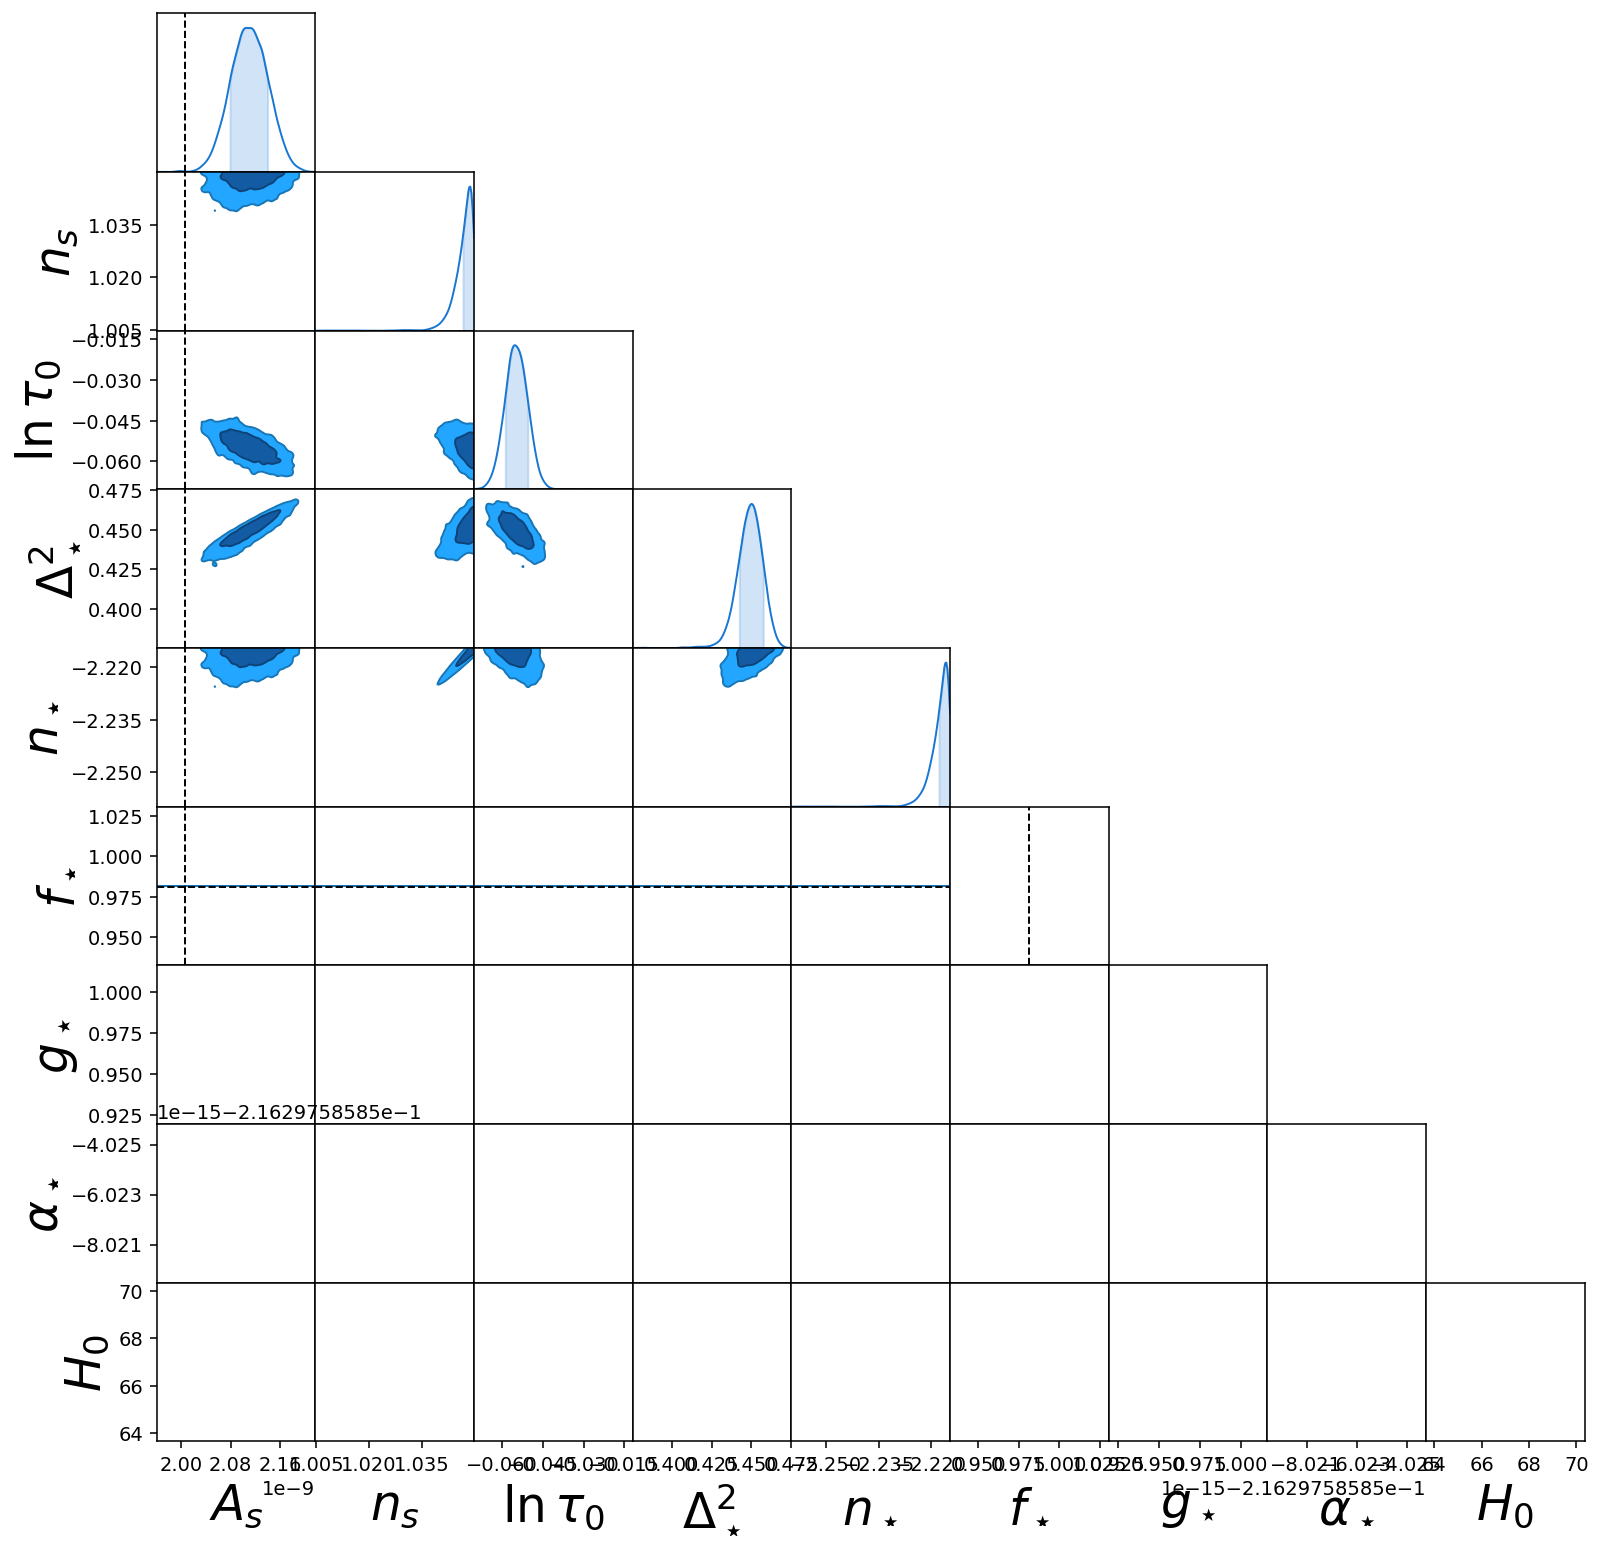

In [14]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

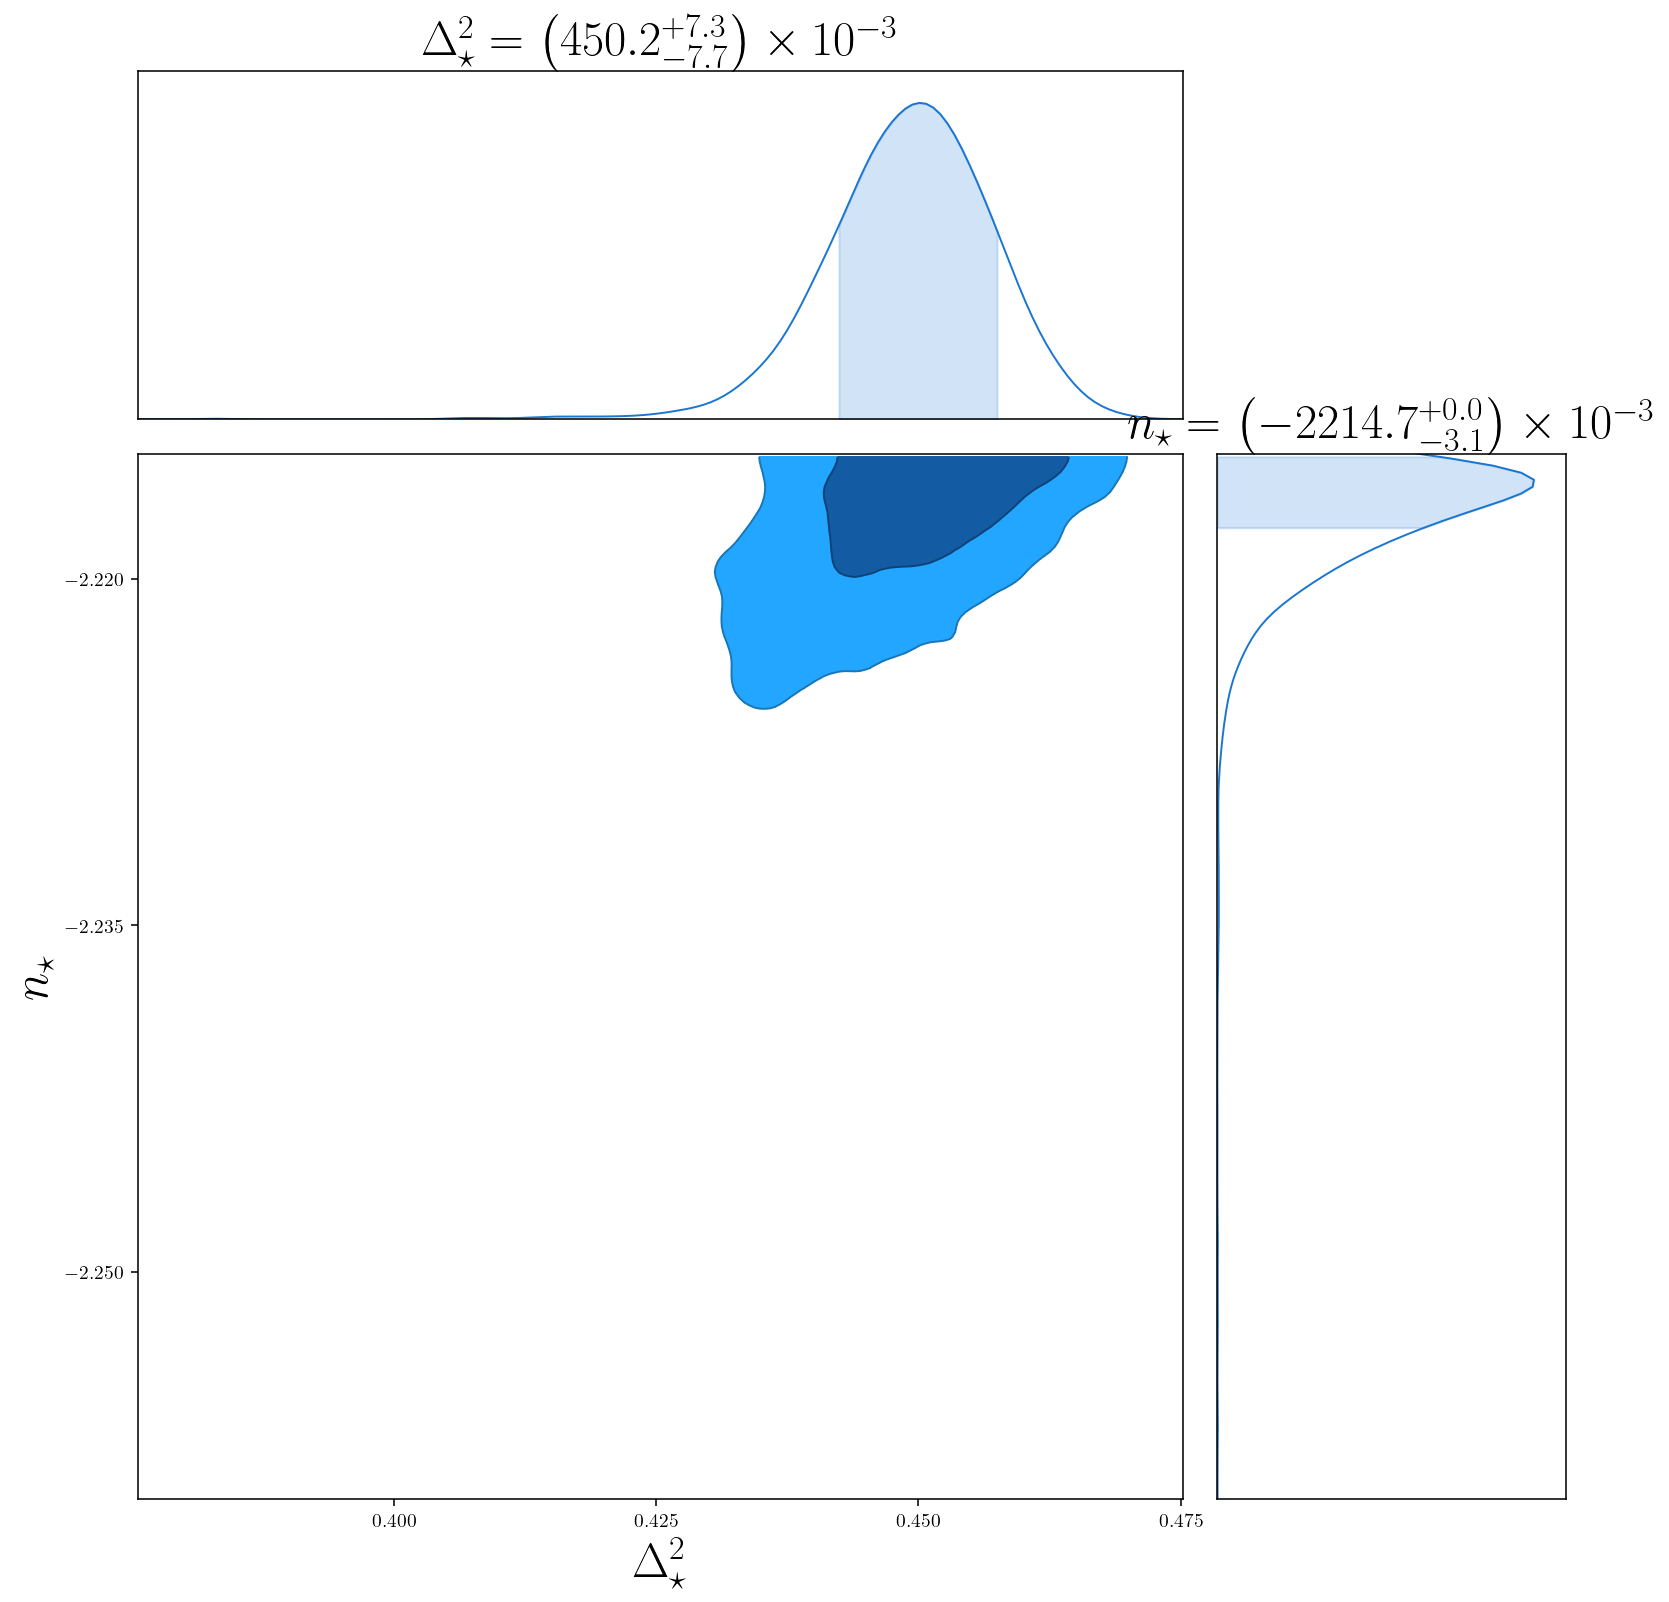

In [15]:
sampler.plot_corner(cmb_prior=False,plot_params=['$\\Delta^2_\\star$','$n_\\star$'],delta_lnprob_cut=50)

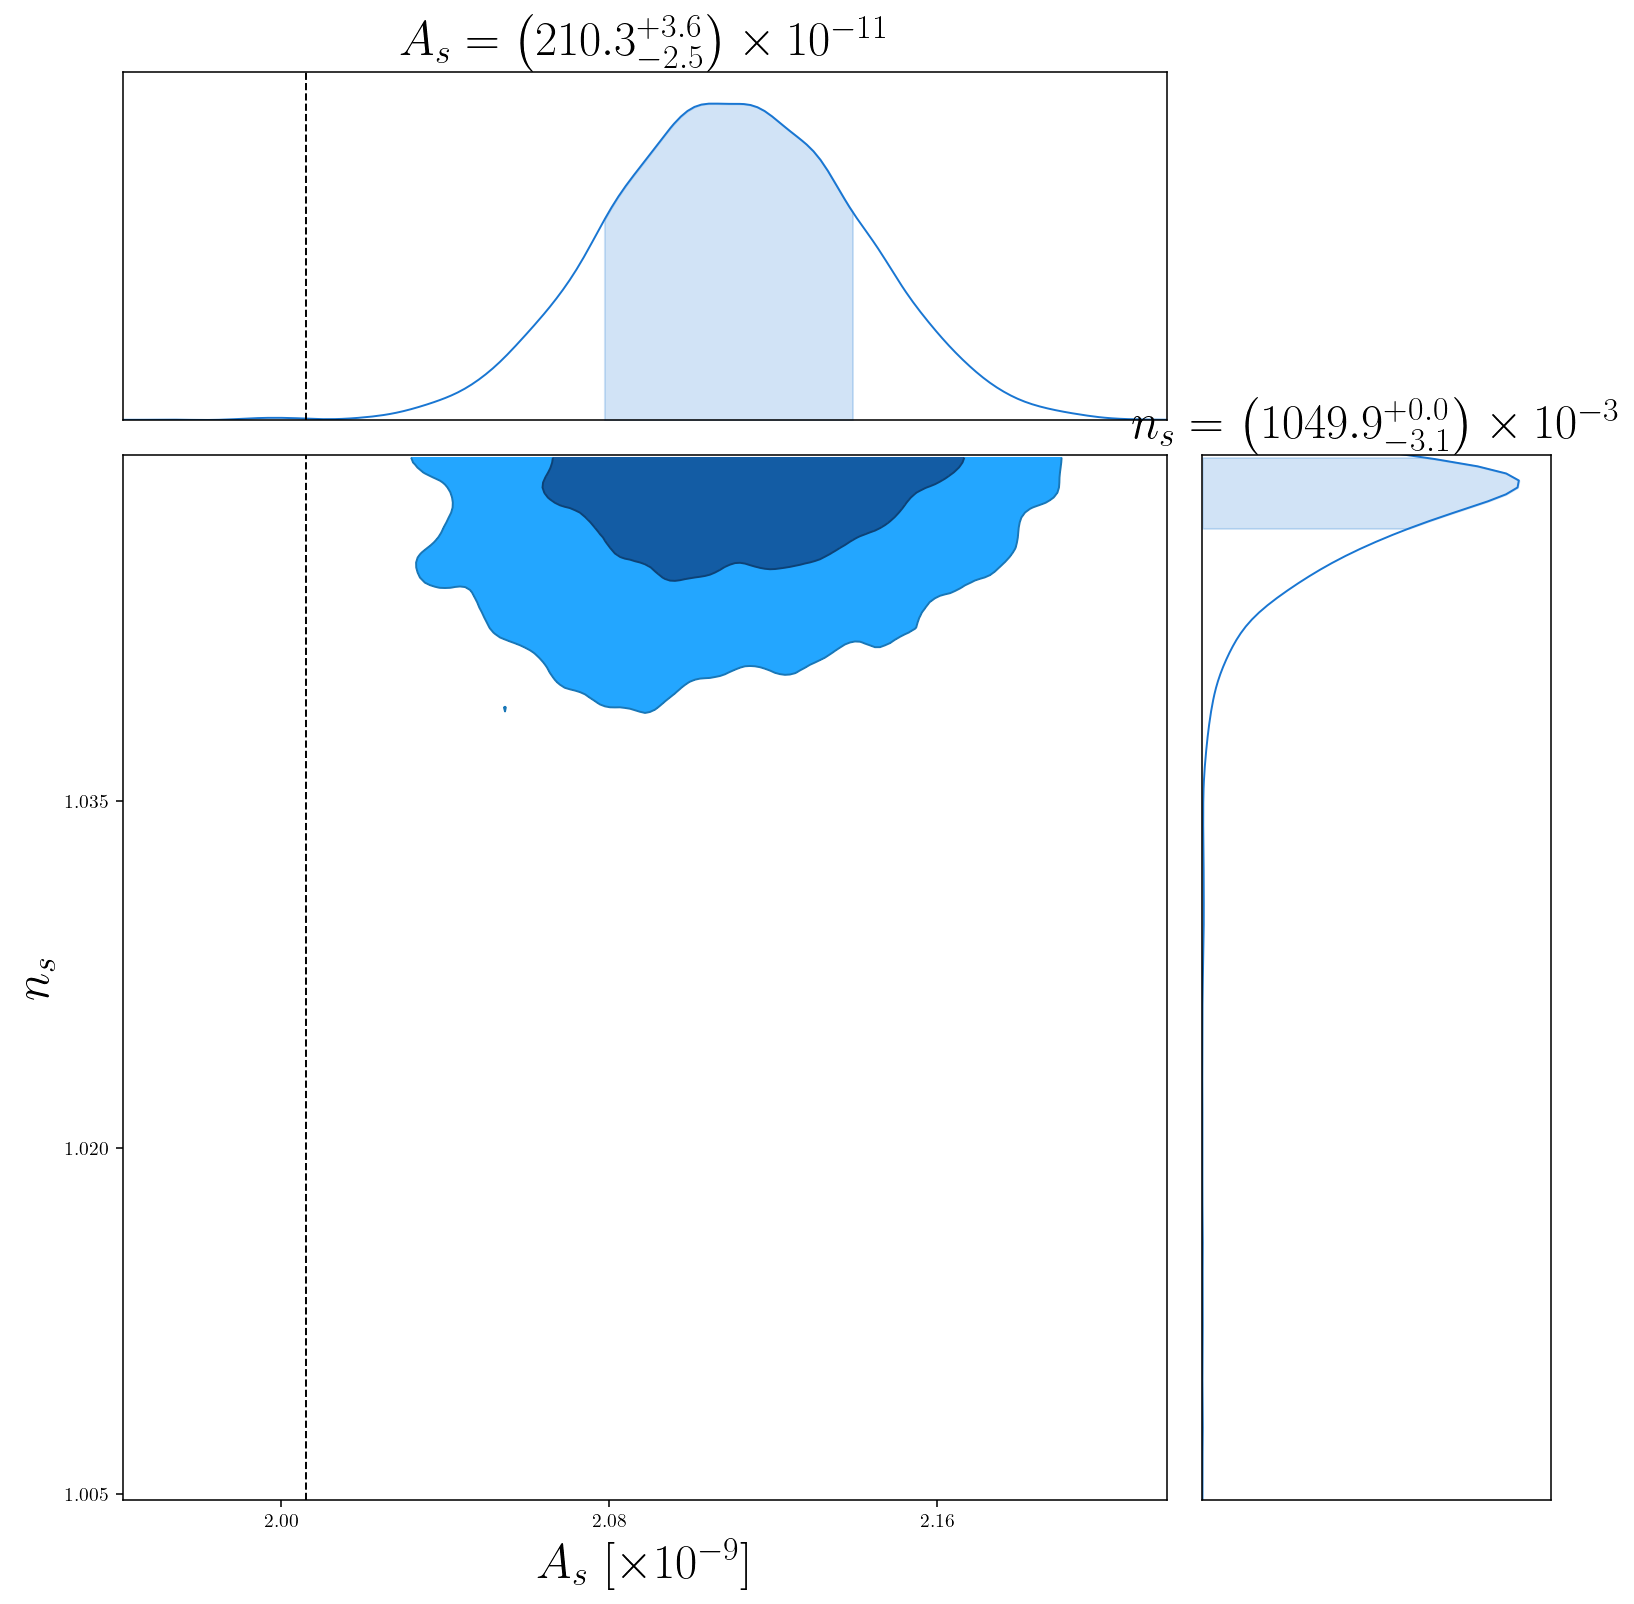

In [16]:
sampler.plot_corner(cmb_prior=False,plot_params=['$A_s$','$n_s$'],delta_lnprob_cut=50)